# Opportunities@MeLi - Code Exercise - Data Scientist

## Description:
In the context of Mercadolibre's Marketplace an algorithm is needed to predict if an item listed in the marketplace is new or used.

Your tasks involve the data analysis, designing, processing and modeling of a machine learning solution to predict if an item is new or used and then evaluate the model over held-out test data.

To assist in that task a dataset is provided in `MLA_100k_checked_v3.jsonlines` and a function `build_dataset` to read that dataset in `new_or_used.py`.

For the evaluation, you will use the accuracy metric in order to get a result of 0.86 as minimum. Additionally, you will have to choose an appropriate secondary metric and also elaborate an argument on why that metric was chosen.

The deliverables are:
* The file, including all the code needed to define and evaluate a model.
* A document with an explanation on the criteria applied to choose the features, the proposed secondary metric and the performance achieved on that metrics. Optionally, you can deliver an EDA analysis with other format like .ipynb


# EDA (exploracion de datos)
En este notebook, se analizaran los datos contenidos en MLA_100k.jsonlines para desarrollar un modelo supervisado de calsificacion binaria que determinara si un producto es nuevo o usado.

principalmente para cada variable se debe observara si:

- Es viable para ser utilizada para el modelo o debe ser descartada. los criterios para determinar si debe ser descartada son:
    - ¿Es un identificador unico?
    - ¿Los valores de la columna son nulos?
    - ¿La informacion de columna es redundante con otra columna?
    - Criterio de experto
- Necesita alguna transformacion o procesamiento para ser util en el modeo 
- su distribucion e informacion descriptiva propia de la variable

## Libraries imports

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import geopy.distance

from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk


nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Paul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Declaracion de funciones

In [215]:
# You can safely assume that `build_dataset` is correctly implemented
def build_dataset():
    data = [json.loads(x) for x in open("../data/MLA_100k.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

def cantidad_distintos_nulo(df,lst_cols):
    text_cols = df[lst_cols].select_dtypes(include=['object', 'string']).columns
    df_cp = df.copy()
    df_cp.loc[:,text_cols] = df_cp[text_cols].replace("", np.nan)
                           
    df_isna = pd.DataFrame(df_cp[lst_cols].isna().sum(), columns=["cantidad_valores_nulos"])
    df_isna["pct_valores_nulos"] = df_isna["cantidad_valores_nulos"]/df.shape[0]
    df_isna = df_isna.sort_values(by="pct_valores_nulos", ascending=False)
    return df_isna
    
    
def descr_categorico(df,col,col_target=None, is_target=False, graficar=True):
    
    if is_target:
        gr_col = df.groupby([col])[["id"]].count()
        gr_col.columns = ["cantidad_registros"]
        gr_col = gr_col.reset_index()
        gr_col.columns = [col,"cantidad_registros"]
        gr_col["porcentaje"] = (100*gr_col["cantidad_registros"]/gr_col["cantidad_registros"].sum()).round(2)

        display(gr_col.sort_values(by="porcentaje",ascending=False))
        if graficar:
            n_cols = 1
            n_rows = 1
            
            fig,ax = plt.subplots(n_cols,n_rows,figsize=(n_rows*5, n_cols*3))
            sns.barplot(gr_col, x=col, y="cantidad_registros", hue=col, ax=ax)
            fig.suptitle(f"Grafica de valores para la columna {col}", fontsize=10, y=1.02)
    else:
        gr_condition = df.groupby([col,col_target])[["id"]].count()
        gr_condition.columns = ["cantidad_registros"]
        gr_condition = gr_condition.reset_index()
        gr_condition["porcentaje"] = (100*gr_condition["cantidad_registros"]/gr_condition.groupby(col)["cantidad_registros"].transform("sum")).round(2)
        gr_col = gr_condition.groupby([col])[["cantidad_registros"]].sum().reset_index()
        gr_col["porcentaje"] = (100*gr_col["cantidad_registros"]/gr_col["cantidad_registros"].sum()).round(2)

        display(gr_col.sort_values(by="porcentaje",ascending=False))
        display(gr_condition)
        if graficar:
            n_cols = 1
            n_rows = 2

            fig,ax = plt.subplots(n_cols,n_rows,figsize=(n_rows*10, n_cols*6))
            axs=ax.flatten()            

            sns.barplot(gr_col, x=col, y="porcentaje", hue=col, ax=axs[0])
            sns.barplot(gr_condition, x=col, y="porcentaje", hue=col_target, ax=axs[1])
            fig.suptitle(f"Grafica de valores para la columna {col}", fontsize=10, y=1.02)
            ax[0].set_title("distribucion de valores")
            ax[1].set_title(f"distribucion de valores en referencia a variable objetivo {col_target}")


def desc_continuous(df,col,col_target):
    print(df[col].isna().sum())
    desc_df_col = df[[col]].describe().T
    desc_df_target = df.groupby(col_target)[[col]].describe()

    display(desc_df_col)
    display(desc_df_target)

    n_rows = 2
    n_cols = 2

    fig,ax = plt.subplots(n_rows,n_cols,figsize=(n_cols*10, n_rows*6))
    axs = ax.flatten()

    sns.kdeplot(data=df, x=col, ax=axs[0])
    sns.kdeplot(data=np.log(df[col]), ax=axs[1])
    sns.kdeplot(data=df, x=col, hue=col_target, ax=axs[2])

    df_dummy = df[[col,col_target]]
    df_dummy.loc[:,col] = np.log(df_dummy[col])

    sns.kdeplot(data=df_dummy,x=col, hue=col_target, ax=axs[3])
    axs[0].set_title("distribucion variable {}".format(col))
    axs[1].set_title("distribucion variable {} - log transformacion".format(col))
    axs[2].set_title("distribucion variable {} con variable objetivo".format(col,col_target))
    axs[3].set_title("distribucion variable {} con variable objetivo {} - log transformacion".format(col,col_target))
    
    
def explore_json_column(df,col,limit=0):
    df_json = df.loc[df[col].str.len() > limit,col].\
                                explode(col).\
                                reset_index()

    df_json = pd.json_normalize(df_json[col])
    return df_json


def valida_contenido_json(col_data, limit=0):
    val = (col_data.str.len() > limit).sum()
    return [val,val/len(col_data)]

def crear_wordcloud(df,column):
    # WordCloud
    fltr = ~df[column].replace("",np.nan).isna()
    text = " ".join(df.loc[fltr,column].str.lower().unique())

    # Generate a word cloud
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='viridis',
        max_words=20,
        stopwords=spanish_stopwords
    ).generate(text)

    # Display the word cloud
    plt.figure(figsize=(7, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud de {column}: top 20 palabras", fontsize=16)
    plt.show()

## Preparacion de datos

In [216]:
# lectura de informacion cruda y separacion en datos de train y test
X_train, y_train, X_test, y_test = build_dataset()

# procesamiento para la lectura de archivos del tipo json
df = pd.json_normalize(X_train, sep='_')
print("Train:")
print(f"numero de filas: {df.shape[0]}.\nnumero de columnas: {df.shape[1]}")

Train:
numero de filas: 90000.
numero de columnas: 92


### Eliminar variables
En esta seccion se mostraran las variables que fueron eliminadas y los criterios por los cuales fueron descartadas

#### identificadores unicos
las siguientes columnas no seran parte del modelo por ser identificadores unicos que no dan valor al modelo

* id 
* thumbnail 
* secure_thumbnail
* permalink

In [217]:
col_unique = ["thumbnail","secure_thumbnail","permalink"]

df_info = pd.DataFrame(df[col_unique].nunique(), columns=["cant_valores_unicos"])
df_info["pct_valores_unicos"] = df_info["cant_valores_unicos"]/df.shape[0]
df_info

,cant_valores_unicos,pct_valores_unicos
thumbnail,88227,0.9803
secure_thumbnail,88227,0.9803
permalink,90000,1.0000


#### Columnas con unico valor
Las columnas a continuacion tienen un unico valor en toda la base, por lo que no dan valor al modelo

* site_id
* location_country_id
* location_country_name
* international_delivery_mode

In [218]:
col_un_valor = ["site_id","location_country_id","location_country_name","international_delivery_mode"]
df_info = pd.DataFrame(df[col_un_valor].nunique(), columns=["cant_valores_unicos"])
df_info

,cant_valores_unicos
site_id,1
location_country_id,1
location_country_name,1
international_delivery_mode,1


In [219]:
# Drop de columnas
df_EDA = df.drop(columns=col_unique + col_un_valor)
print("df con transformacion:")
print(f"numero de filas: {df_EDA.shape[0]}.\nnumero de columnas: {df_EDA.shape[1]}")

df con transformacion:
numero de filas: 90000.
numero de columnas: 85


#### Valores faltantes
En esta seccion se analizaran los datos que tienen valores faltantes, algunas columnas tienen string vacios dentro de sus valores, los cuales cuentan como vacio

- seller_contact
- location_zip_code
- differential_pricing
- location_open_hours
- subtitle
- listing_source
- seller_contact_webpage
- catalog_product_id
- shipping_dimensions
- seller_contact_phone2
- seller_contact_area_code2
- seller_contact_other_info
- coverage_areas 
- shipping_methods
- shipping_tags

In [220]:
df_nulos = cantidad_distintos_nulo(df_EDA,df_EDA.columns)
df_nulos[df_nulos["pct_valores_nulos"]>0.9].head(12)

C:\Users\Paul\AppData\Local\Temp\ipykernel_31736\305274061.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cp.loc[:,text_cols] = df_cp[text_cols].replace("", np.nan)


,cantidad_valores_nulos,pct_valores_nulos
location_open_hours,90000,1.000000
subtitle,90000,1.000000
seller_contact,90000,1.000000
seller_contact_webpage,90000,1.000000
listing_source,90000,1.000000
location_zip_code,90000,1.000000
differential_pricing,90000,1.000000
catalog_product_id,89993,0.999922
shipping_dimensions,89978,0.999756
seller_contact_area_code2,89971,0.999678


In [221]:
cols_val_faltantes = ["seller_contact", "location_zip_code", "differential_pricing",
       "location_open_hours", "subtitle", "listing_source",
       "seller_contact_webpage", "catalog_product_id", "shipping_dimensions",
       "seller_contact_phone2", "seller_contact_area_code2",
       "seller_contact_other_info"]

df_val_faltantes = pd.DataFrame(df_EDA[cols_val_faltantes].replace("",np.nan).nunique(), columns=["num_valores_unicos"])
df_val_faltantes.sort_values(by = "num_valores_unicos")

C:\Users\Paul\AppData\Local\Temp\ipykernel_31736\474945139.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_val_faltantes = pd.DataFrame(df_EDA[cols_val_faltantes].replace("",np.nan).nunique(), columns=["num_valores_unicos"])


,num_valores_unicos
seller_contact,0
location_zip_code,0
differential_pricing,0
location_open_hours,0
subtitle,0
listing_source,0
seller_contact_webpage,0
seller_contact_area_code2,3
catalog_product_id,7
seller_contact_phone2,11


En esta seccion se revisa de las columnas que tienen como valores listas o arrays, los que estan vacios y por lo tanto deben ser eliminados.

In [222]:
cols_val_faltantes_json = ["coverage_areas","shipping_methods","shipping_tags","deal_ids"]
df_val_fantantes_json = df_EDA[cols_val_faltantes_json].apply(lambda col: valida_contenido_json(col), result_type='expand').T
df_val_fantantes_json.columns=["cantidad_distintos_nulo","pct_distintos_nulo"]
df_val_fantantes_json

,cantidad_distintos_nulo,pct_distintos_nulo
coverage_areas,0.0,0.000000
shipping_methods,0.0,0.000000
shipping_tags,59.0,0.000656
deal_ids,217.0,0.002411


In [223]:
df_EDA = df_EDA.drop(columns=cols_val_faltantes+cols_val_faltantes_json)
print("df con transformacion:")
print(f"numero de filas: {df_EDA.shape[0]}.\nnumero de columnas: {df_EDA.shape[1]}")

df con transformacion:
numero de filas: 90000.
numero de columnas: 69


#### Redundancia de informacion
En esta seccion se eliminan ciertas variables que pueden estar ya contenidas en otra columna. 

##### Por nombre
Se elige entre los pares de variables (nombre variable)**_id** y (nombre variable)**_name**, como la variable name es mas interpretable se conservan estas variables

In [224]:
cols_redundantes_por_nombre = ['seller_address_country_id',
                               'seller_address_search_location_neighborhood_id',
                               'seller_address_search_location_state_id',
                               'seller_address_search_location_city_id',
                               'seller_address_city_id', 
                               'seller_address_state_id',
                               'location_neighborhood_id',
                               'location_city_id', 
                               'location_state_id']

##### Por ubicacion geografica
A continuacion se evalua la redundancia de las variables geograficas, las siguientes columnas son eliminadas

- geolocation_latitude 
- geolocation_longitude
- seller_address_search_location_state_name
- seller_address_id

luego de evaluar las variables anteriores frente a otras columnas se determina que son iguales o lo suficientemente similares a otra columna como para ser descartadas. a continuacion el analisis en detalle.

In [225]:
cols_redundates_geograficas = ['geolocation_latitude',
                               'geolocation_longitude',
                               'seller_address_search_location_state_name',
                               'seller_address_id']

Se analizan las coordenadas para determinar si son las mismas, para ello se evalua a que distancia se encuentran las unas de las otras.

con la transformacion y analisis de las variables se determina que el **0.111%** de las coordenadas esta a una distancia mayor de 10km de su par, por lo que se considerará que las coordenadas son "iguales" y por lo tanto se puede eliminar un par de variables.

In [226]:
df_geoloc = df_EDA[['geolocation_latitude','geolocation_longitude',
        'seller_address_latitude','seller_address_longitude']].astype(str).apply(lambda col: col.replace("", np.nan)).astype(float)

# eliminar coordenadas vacias
df_geoloc = df_geoloc.dropna()
#crear coordenadas
df_geoloc['geolocation_coordinates'] = df_geoloc.apply(lambda row: (row['geolocation_latitude'], row['geolocation_longitude']), axis=1)
df_geoloc['seller_addres_coordinates'] = df_geoloc.apply(lambda row: (row['seller_address_latitude'], row['seller_address_longitude']), axis=1)
#calcular distancias
df_geoloc["distance"] = df_geoloc.apply(lambda row : geopy.distance.geodesic(row['geolocation_coordinates'], row['seller_addres_coordinates']).km,
                                        axis=1)
df_geoloc.sort_values(by="distance", ascending = False)
# informacion final
fltr = df_geoloc["distance"] <= 10
print("pct de coordenadas iguales o a una distancia menor a 10km: {pct:.3f}".format(pct=100*sum(fltr)/len(fltr)))
print("pct de coordenadas iguales o a una distancia MAYOR a 10km: {pct:.3f}".format(pct=100*sum(~fltr)/len(fltr)))

pct de coordenadas iguales o a una distancia menor a 10km: 99.889
pct de coordenadas iguales o a una distancia MAYOR a 10km: 0.111


Al comparar las columnas <span style="color: green;">**seller_address_state_name**</span> y <span style="color: red;">**seller_address_search_location_state_name**</span> se evidencia que la primera agrupa a la segunda, por lo tanto se decide prescindir de la segunda.

In [227]:
df_EDA.groupby(['seller_address_state_name','seller_address_search_location_state_name'])[["id"]].count().sort_values(by='id', ascending=False)

id
seller_address_state_name seller_address_search_location_state_name       
Capital Federal           Capital Federal                            52142
Buenos Aires              Bs.As. G.B.A. Sur                           8249
                          Bs.As. G.B.A. Norte                         7959
                          Bs.As. G.B.A. Oeste                         7498
                                                                      3507
Santa Fe                  Santa Fe                                    2392
Buenos Aires              Buenos Aires Interior                       2370
Córdoba                   Córdoba                                     1720
Buenos Aires              Bs.As. Costa Atlántica                      1450
                          Capital Federal                              448
Mendoza                   Mendoza                                      400
Chubut                    Chubut                                       334
Entre Ríos                Entre Ríos                                   247
Tucumán                   Tucumán                                      212
San Juan                  San Juan                                     132
Salta                     Salta                                        129
Misiones                  Misiones                                     122
Río Negro                 Río Negro                                    119
Corrientes                Corrientes                                   109
Neuquén                   Neuquén                                       85
La Pampa                  La Pampa                                      69
Chaco                     Chaco                                         66
San Luis                  San Luis                                      56
Jujuy                     Jujuy                                         33
Formosa                   Formosa                                       26
Santiago del Estero       Santiago del Estero                           26
Santa Cruz                Santa Cruz                                    22
Catamarca                 Catamarca                                     20
La Rioja                  La Rioja                                      16
Tierra del Fuego          Tierra del Fuego                              10
Córdoba                                                                  7
Santa Fe                                                                 6
Chaco                                                                    3
Tucumán                                                                  2
Formosa                                                                  2
Salta                                                                    2
Neuquén                                                                  2
Entre Ríos                                                               2
La Pampa                                                                 1
Corrientes                                                               1
Chubut                                                                   1
Capital Federal                                                          1
Buenos Aires              Santa Fe                                       1
                                                                         1

La siguiente variable es <span style="color: red;">**seller_addres_id**</span> esta variable es redundante con <span style="color: green;">**seller_id**</span>, como se evidencia en la siguiente celda solo un par de *sellers* tienen mas de una direccion por lo que se puede eliminar la variable

In [228]:
gr_0 = df_EDA.groupby(['seller_id','seller_address_id'])[["id"]].count().reset_index()
gr = gr_0.groupby(["seller_id"])[["seller_address_id"]].count().sort_values(by="seller_address_id", ascending=False).head(10)
gr

,seller_address_id
seller_id,
35851775,2
58391698,2
15816492,2
138094599,2
58597029,2
158994601,2
95024038,2
126942409,1
126947873,1


In [229]:
cols_redundantes = cols_redundantes_por_nombre + cols_redundates_geograficas
df_EDA = df_EDA.drop(columns=cols_redundantes)
print("df con transformacion:")
print(f"numero de filas: {df_EDA.shape[0]}.\nnumero de columnas: {df_EDA.shape[1]}")

df con transformacion:
numero de filas: 90000.
numero de columnas: 56


#### Criterio experto
En esta seccion se muestran los criterios para eliminar ciertas variables a partir del analisis de los valores de estas.

- last_updated
- start_time
- stop_time
- seller_address_comment
- seller_address_address_line
- seller_address_city_name
- seller_address_zip_code
- sub_status
- shipping_free_methods
- status
- currency_id
- seller_address_country_name

##### A priori
En esta seccion se eliminan las variables que per se no se consideran que aporten valor, sin un analisis profundo, las variables elegidas son dependientes del tiempo.

- last_updated
- start_time
- stop_time


In [230]:
cols_apriori = ['last_updated','start_time',
                'stop_time','date_created']
df_EDA = df_EDA.drop(columns=cols_apriori)
print("df con transformacion:")
print(f"numero de filas: {df_EDA.shape[0]}.\nnumero de columnas: {df_EDA.shape[1]}")

df con transformacion:
numero de filas: 90000.
numero de columnas: 52


##### Variables de Texto (NLP)
A las siguientes variables se les realiza un analisis de bag of words para determinar el contenido de las columnas. las variables a continuacion dan detalle de la direccion del cliente como avenida, departamento etc. y por lo tanto no se considera que sean candidatas para un modelo.

- seller_address_comment
- seller_address_address_line
- title*

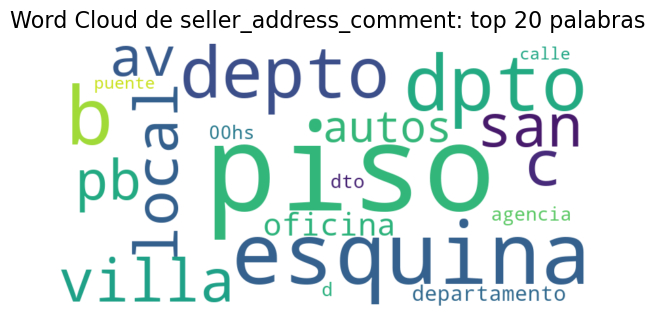

In [231]:
crear_wordcloud(df_EDA,"seller_address_comment")

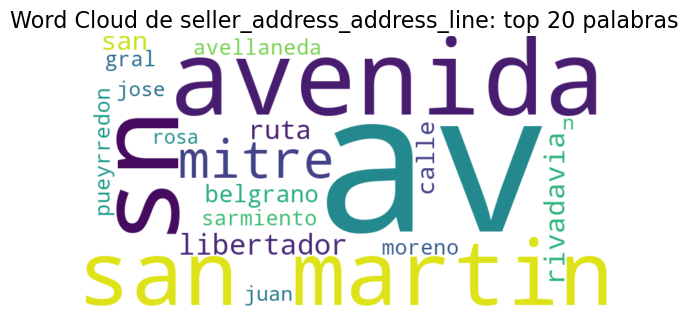

In [232]:
crear_wordcloud(df_EDA,'seller_address_address_line')

la variable **title** es particular, si bien se observa que tiene un gran valor ya que contiene palabras clave no se incluira incialmente en el analisis ya que para obtener un mejor resultado de esta variable se debe aplicar un proceso de NLP y para una version incial del modelo no se tendrá en cuenta.

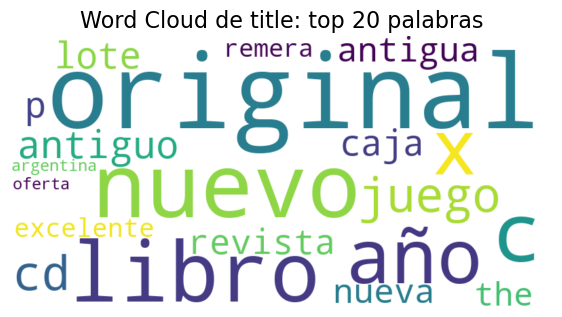

In [233]:
crear_wordcloud(df_EDA,'title')

##### Alta granularidad

no se consideran estas variables por que aumentarian la dimensionalidad del dataset, ademas al ser variables geograficas estas son redundantes con otras variables ya que estas pueden estar contenidas en otras columnas como por ejemplo: **seller_address_search_location_city_name**

- seller_address_city_name
- seller_address_zip_code
- seller_address_search_location_neighborhood_name

In [234]:
df_EDA[['seller_address_city_name',
        'seller_address_zip_code',
        'seller_address_search_location_neighborhood_name']].nunique()

seller_address_city_name                            3480
seller_address_zip_code                              299
seller_address_search_location_neighborhood_name     536
dtype: int64

##### Variables sin relacion al producto ofertado 

Las siguientes variables no tienen relacion con el producto ofertado, una de estas es el estado del anuncio, y la segunda no es intepretable por lo que deciden eliminarse

- sub_status
- status

In [235]:
cols = ["sub_status","status"]
display(df_EDA[cols].apply(lambda col: valida_contenido_json(col), result_type='expand').T)

,0,1
sub_status,891.0,0.0099
status,90000.0,1.0000


In [236]:
df_EDA.loc[df_EDA["sub_status"].str.len() > 0,"sub_status"].str[0].unique()

array(['suspended', 'expired', 'deleted'], dtype=object)

In [237]:
descr_categorico(df_EDA,'status',is_target=True, graficar=False)

,status,cantidad_registros,porcentaje
0,active,86116,95.68
3,paused,3863,4.29
1,closed,20,0.02
2,not_yet_active,1,0.00


##### Variables hegemonicas

estas variables tienen una mayoria evidente frente a otros valores de la columna, siendo casi iguales a las columnas de valores unicos, por tal motivo se decide descartar estas variables.

- currency_id
- seller_address_country_name

0


,currency_id,cantidad_registros,porcentaje
0,ARS,89496,99.44
1,USD,504,0.56


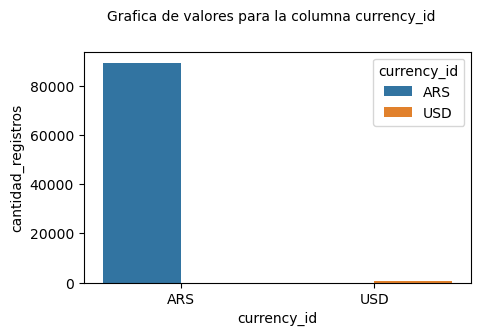

In [238]:
col = "currency_id"
print(df_EDA[col].isna().sum())
descr_categorico(df_EDA,col,is_target=True)

,seller_address_country_name,cantidad_registros,porcentaje
1,Argentina,89999,100.0
0,,1,0.0


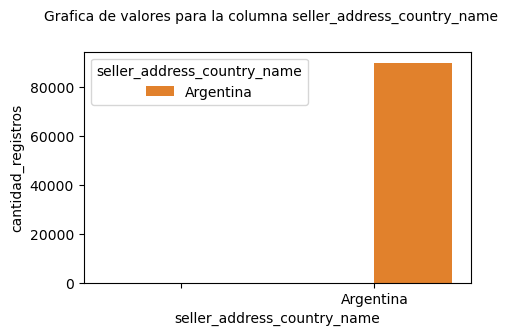

In [239]:
descr_categorico(df_EDA,'seller_address_country_name',is_target=True)

In [240]:
cols_criterio_exp = ["seller_address_comment",
                "seller_address_address_line",
                "title",
                "seller_address_city_name",
                "seller_address_zip_code",
                "seller_address_search_location_neighborhood_name",
                "sub_status",
                "status",
                "currency_id",
                "seller_address_country_name"]

df_EDA = df_EDA.drop(columns=cols_criterio_exp)
print("df con transformacion:")
print(f"numero de filas: {df_EDA.shape[0]}.\nnumero de columnas: {df_EDA.shape[1]}")

df con transformacion:
numero de filas: 90000.
numero de columnas: 42


### Transformar variables

En esta seccion se evaluaran de forma descriptiva las variables y las transformaciones que pueden ser aplicadas a estas para que tengan un mayor poder preductivo en el modelo.

#### Binarizacion

Las siguientes columnas son transformadas a valores binariosque indica la presencia o no del atributo de la columna, los valores en dichas columnas se pueden interpretar de la siguiente manera.
<center>

| valores binarios | interpretacion     |
|------------------|--------------------|
| 1                | presente           |
| 0                | no esta presente   |

</center>

##### Booleano a numerico
Las siguientes columnas estan almacenadas como booleanos y seran transformados a valores numericos para que la base este estandarizada con el criterio anterior

In [241]:
lst_binary_boolean_to_numeric = ["accepts_mercadopago", 
                                "automatic_relist", 
                                "shipping_local_pick_up",
                                "shipping_free_shipping"
                                ]
df_EDA[lst_binary_boolean_to_numeric] = df_EDA[lst_binary_boolean_to_numeric].astype(int)

##### Simplificacion - directa

Las siguientes columnas tienen distintos valores, para el modelo se determina que estas variables se transformaran a binario, para obtener una mejor interpretacion de las variables.

Estas variables pueden transformarse a binario simplemente determinando si el campo existe o no

- **warranty**: posee un texto que describe la garantia, se determina que el texto sera "descartado" pero se conservará una variable que indique si el articulo tenia un texto de garantia o no.

- **video_id**: esta columna tiene un identificador codificado del video el cual no brinda valor, sin embargo se cambia por un valor binario que indica si el producto tiene o no un video 

- **official_store_id**: en este caso el identificador de la columna no es entendible, sin embargo saber si el producto esta asociado a una tienda oficial puede ser util

- **parent_item_id**: esta relacionado con una republicacion ([referencia](https://stackoverflow.com/questions/40478704/mercadolibre-api)), si tiene un *parent* quiere decir que hubo una republicacion

In [242]:
lst_binary_exists = ["warranty",
                    "parent_item_id", 
                    "official_store_id",
                    "video_id"
                    ]

fltr = (~df_EDA[lst_binary_exists].isna()).sum(axis=1) == 4
df_EDA.loc[fltr,lst_binary_exists]

,warranty,parent_item_id,official_store_id,video_id
537,Garantía Oficial.,MLA567312114,170.0,YU2f8ZoDqo0
12002,2 Años de Garantía Oficial Philips Argentina,MLA574144107,221.0,cjHCzC69tyw
41823,7 Años de garantía escrita por AISA IONIC S.A,MLA567252400,322.0,WkGGZndnDXo
42752,Garantía por 3 meses por roturas por fallas de...,MLA569497696,256.0,I_YZIt3Ax_M
50867,Garantía Oficial,MLA567311012,170.0,YU2f8ZoDqo0
54010,Garantía por 3 meses. Devoluciones solo por ro...,MLA573808578,256.0,Z5uTGNn2cwY
67638,Garantía por 3 meses. Devoluciones solo por ro...,MLA569556438,256.0,DZ0x58a_L4s
89572,Garantía por 3 meses. Devoluciones solo por ro...,MLA565356957,256.0,WKo_6fssxnc


In [243]:
df_EDA[lst_binary_exists] = (~df_EDA[lst_binary_exists].isna()).astype(int)

- **shipping_free_methods:**([referencia meli](https://developers.mercadolibre.com.ar/en_us/free-shipping-mshops)) esta variable indica si el producto tiene asociado un tipo de envio gratuito, esta almacenado como un json por lo que la transformacion a binario difiere de los datos anteriores

In [244]:
df_EDA["shipping_free_methods"] = (df_EDA["shipping_free_methods"].str.len() > 0).astype(int)

##### Simplificacion - indirecta

Para las siguientes columnas la conversion a binario implica no solo la transformacion a presente o no del valor si no que transforma la variable en una nueva, lo que significa que <span style="color: orange;">la variable original será eliminada y reemplazada por la nueva.</span>

- **buying_mode:** al observar las categorias se determina que esta variable, puede cambiarnse por una nueva que indica si el producto tiene asociada la propiedad de buy_now

,buying_mode,cantidad_registros,porcentaje
1,buy_it_now,87311,97.01
2,classified,1982,2.20
0,auction,707,0.79


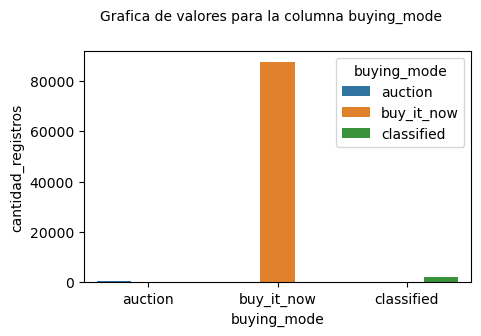

In [245]:
descr_categorico(df_EDA,'buying_mode',is_target=True)

- **seller_address_state_name:** para esta variable se evidencia una gran cantidad de productos se venden en la capital, por lo que se creara una variable que indique si el producto es vendido en la capital

In [246]:
descr_categorico(df_EDA,'seller_address_state_name',is_target=True, graficar=False)

,seller_address_state_name,cantidad_registros,porcentaje
2,Capital Federal,52143,57.94
1,Buenos Aires,31482,34.98
21,Santa Fe,2398,2.66
7,Córdoba,1727,1.92
13,Mendoza,400,0.44
5,Chubut,335,0.37
8,Entre Ríos,249,0.28
24,Tucumán,214,0.24
18,San Juan,132,0.15
17,Salta,131,0.15


**shipping_mode**
[fuente meli](https://developers.mercadolibre.com.ec/mercado-envios)

- Mercado Envíos 1 (ME1): es una modalidad de envío que permite a los vendedores vender a través de Mercado Libre, utilizando su propia logística o servicios de terceros.
- Mercado Envíos 2 (ME2): es la modalidad de envío de Mercado Libre, donde se gestiona toda la logística utilizando diversos medios como correos, agencias, entre otros. Esta modalidad se divide a su vez en los siguiente tipos de logística:
    - Mercado Envíos Drop_off
    - Mercado Envíos Colectas (cross_docking) y Places (xd_drop_off)
    - Mercado Envíos Flex (self_service)
    - Mercado Envíos Turbo (turbo)
    - Mercado Envíos Full (fulfillment)
- Custom: es una modalidad de envío donde el vendedor carga una tabla con los precios de envío por cada región y se encarga de la logística.
- Not Specified: es una modalidad de envío donde el vendedor no especifica ningún precio de envío para sus publicaciones y debe ponerse en contacto con el comprador para coordinar el envío.

esta variable se transformara en binaria y sera un flg que cuando sea igual a not_specified = 1 de resto sera 0

,shipping_mode,cantidad_registros,porcentaje
2,me2,46059,51.18
3,not_specified,40725,45.25
0,custom,3130,3.48
1,me1,86,0.10


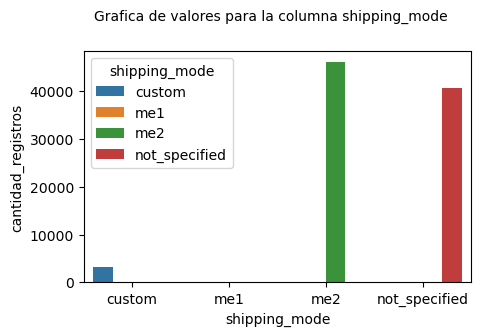

In [247]:
descr_categorico(df_EDA,"shipping_mode",is_target=True)

In [248]:
df_EDA["flg_buy_it_now"] = df_EDA["buying_mode"].isin(["buy_it_now"]).astype(int)
df_EDA["flg_is_capital_city"] = df_EDA["seller_address_state_name"].str.lower().isin(["capital federal"]).astype(int)
df_EDA["flg_ship_not_specified"] = df_EDA["shipping_mode"].isin(["not_specified"]).astype(int)

df_EDA = df_EDA.drop(columns=["buying_mode","seller_address_state_name","buying_mode"])

##### Variable inmobiliaria

las siguientes variables se relacionan entre si ya que al analizar la cantidad de valores faltantes es evidente que es el mismo valor para todas estas columnas, por lo que se infiere que todas estas variables pueden indicar la presencia o no de algo.

Al analizar el valor de la variable *seller_contact_contact* con un wordCloud se evidencia que el tema comun es bienes raices. 

Por lo tanto las columnas enunciadas a continuacion **seran reemplazadas** por un ***flag* que indica que es del tipo inmobiliario** cuando hay un valor en la variable *seller_contact_contact*

- seller_contact_email
- seller_contact_contact
- seller_contact_area_code
- seller_contact_phone
- location_neighborhood_name
- location_longitude
- location_address_line
- location_latitude
- location_city_name
- location_state_name

In [249]:
# analisis de valores nulos
cols_location = ['seller_contact_email', 'seller_contact_contact',
       'seller_contact_area_code', 'seller_contact_phone',
       'location_neighborhood_name', 'location_longitude',
       'location_address_line', 'location_latitude', 'location_city_name',
       'location_state_name']

df_EDA[cols_location].isna().sum()

seller_contact_email          88018
seller_contact_contact        88018
seller_contact_area_code      88018
seller_contact_phone          88018
location_neighborhood_name    88018
location_longitude            88018
location_address_line         88018
location_latitude             88018
location_city_name            88018
location_state_name           88018
dtype: int64

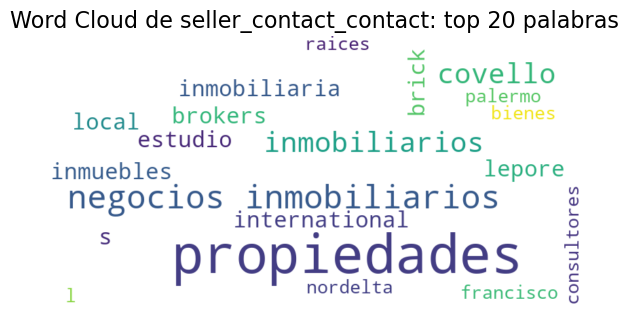

In [250]:
crear_wordcloud(df_EDA,'seller_contact_contact')

In [251]:
# Transformacion
df_EDA["flg_inmobiliario"] = (~df_EDA['seller_contact_contact'].replace("",np.nan).isna()).astype(int)
df_EDA = df_EDA.drop(columns=cols_location)
print("df con transformacion:")
print(f"numero de filas: {df_EDA.shape[0]}.\nnumero de columnas: {df_EDA.shape[1]}")

df con transformacion:
numero de filas: 90000.
numero de columnas: 34


#### Nuevas variables

En esta seccion se exponen las nuevas variables creadas a partir de las existentes, con el objetivo de enriquecer el analisis, a partir de nueva informacion.

##### conteo de elementos
En esta transformacion se realiza el conteo de elementos que esta en cada columna analizada y dicha variable <span style="color: orange;">reemplazará a la original</span>

In [252]:
def transform_num_elements_json(df,col,new_name):
    df[new_name] = df[col].str.len().fillna(0)
    if col != "non_mercado_pago_payment_methods":
        df.drop(columns = [col], inplace=True)
    return df

- **variations:**([referencia meli](https://developers.mercadolibre.com.ar/en_us/variations)) Esta columna tiene informacion de distintas opciones que hay para el producto ofertado, estas opciones pueden ser diferentes colores, tallas entre otras propiedades. En este caso no se busca obtener la informacion alli contenida si no la cantidad de variaciones que tiene cada producto ya que un producto nuevo puede que tenga mas opciones que uno usado ya que en el caso de un usado se esta vendiendo ese unico item

<div style="display: flex; justify-content: center; align-items: center;">
  <img src="../imagenes/tipos_variaciones_1.png" style="height: 150px; margin-right: 10px;"/>
  <img src="../imagenes/tipos_variaciones_2.png" style="height: 150px;"/>
</div>

In [253]:
# cantidad de elementos no nulos
display(df_EDA[["variations"]].apply(lambda col: valida_contenido_json(col), result_type='expand').T)

# ejemplo de un producto con 2 variaciones
explore_json_column(df_EDA,"variations",2).head(2)

,0,1
variations,7374.0,0.081933


,attribute_combinations,seller_custom_field,picture_ids,sold_quantity,available_quantity,id,price
0,"[{'value_id': '92013', 'name': 'Color Primario...",None,"[21897-MLA20219050871_122014, 21826-MLA2021905...",1,2,9391988875,590.0
1,"[{'value_id': '92013', 'name': 'Color Primario...",None,"[21897-MLA20219050871_122014, 21826-MLA2021905...",0,2,9391988878,590.0


In [254]:
df_EDA = transform_num_elements_json(df_EDA,"variations","num_variations")

- **attributes:** ([referencia meli](https://developers.mercadolibre.com.ar/en_us/attributes)) esta variable contiene propiedades del producto, siguiendo la misma logica que con la columna variations, un producto nuevo puede que tenga mas artibutos que uno usado ya que en el caso de un usado se esta vendiendo ese unico item

In [255]:
# cantidad de elementos no nulos
display(df_EDA[["attributes"]].apply(lambda col: valida_contenido_json(col), result_type='expand').T)

explore_json_column(df_EDA,"attributes",4).head(4)

,0,1
attributes,11150.0,0.123889


,value_id,attribute_group_id,name,value_name,attribute_group_name,id
0,,ADICIONALES,Horario de contacto,09 HS A 19 HS,Adicionales,MLA1743-HORPREF
1,MLA1744-COLOREXT-PLATA,ADICIONALES,Color,Plata,Adicionales,MLA1744-COLOREXT
2,MLA1744-DIREC-ASISTIDA,ADICIONALES,Dirección,Asistida,Adicionales,MLA1744-DIREC
3,,ADICIONALES,Único dueño,,Adicionales,MLA1744-OWNER


- **tags:** ([referencia meli](https://developers.mercadolibre.cl/es_ar/publica-productos#Tags-de-un-item)) estos tags dan propiedades de la publicacion, al igual que en los elementos pasados se teoriza que la cantidad de tags pueda ser un indicador del tipo de producto nuevo o usado

In [256]:
# cantidad de elementos no nulos
display(df_EDA[["tags"]].apply(lambda col: valida_contenido_json(col), result_type='expand').T)

df_EDA.loc[df_EDA["tags"].str.len() > 0,"tags"].\
                                explode("tags").unique()

,0,1
tags,67588.0,0.750978


array(['dragged_bids_and_visits', 'good_quality_thumbnail',
       'dragged_visits', 'free_relist', 'poor_quality_thumbnail'],
      dtype=object)

- **pictures:** si bien esta columna contiene mucha informacion de la foto adjunta al producto, que podria ser enriqueecedora como el tamaño y la calidad, en este caso se tendra la variable con la cantidad de fotos adjunta al producto.

<div style="display: flex; justify-content: center; align-items: center;">
  <img src="../imagenes/var_pictures.png" style="height: 200px; margin-right: 10px;"/>
</div>

In [257]:
# cantidad de elementos no nulos
display(df_EDA[["pictures"]].apply(lambda col: valida_contenido_json(col), result_type='expand').T)

explore_json_column(df_EDA,"pictures",2).head(2)

,0,1
pictures,89297.0,0.992189


,size,secure_url,max_size,url,quality,id
0,499x334,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,951x637,http://mla-s1-p.mlstatic.com/23223-MLA20245018...,,23223-MLA20245018984_022015
1,500x375,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,1024x768,http://mla-s2-p.mlstatic.com/23273-MLA20245018...,,23273-MLA20245018989_022015


- **non_mercado_pago_payment_methods:** esta columna contiene informacion de los tipos de metodos de pago aceptados por el vendedor. se transforma en un conteo de la cantidad de metodos ya que se espera que la cantidad de elementos de pagos este relacionado con el tipo de producto.

In [258]:
display(df_EDA[["non_mercado_pago_payment_methods"]].apply(lambda col: valida_contenido_json(col), result_type='expand').T)

explore_json_column(df_EDA,"non_mercado_pago_payment_methods",4).head(4)

,0,1
non_mercado_pago_payment_methods,62469.0,0.6941


,description,id,type
0,MasterCard,MLAMC,C
1,Mastercard Maestro,MLAMS,D
2,Visa Electron,MLAVE,D
3,Contra reembolso,MLACD,G


In [259]:
dict_transform_num_elements = {
    "variations": "num_variations",
    "attributes": "num_attributes",
    "tags":"num_tags",
    "pictures": "num_pictures",
    "shipping_free_methods":"num_shipping_free_methods",
    "non_mercado_pago_payment_methods":"num_payment_methods"
    }
    
for original_column, new_column in dict_transform_num_elements.items():
    df = transform_num_elements_json(df, original_column, new_column)

##### indicador de variacion
Esta transformacion crea una variable que compara dos valores e indica si la diferencia entre estos es positiva, negativa o son iguales, esto por medio de una codigicacion de numeros entre -1 y 1, como es muestra a continuacion

$$
\text{variacion} = \text{valor base} - \text{valor comparado}
$$

<center>

| Valor | Interpretación                                    |
|-------|---------------------------------------------------|
| 1     | Si la variacion es positiva                       |
| 0     | Cuando no existe el dato base o no hay variación  |
| -1    | Si la variacion es negativa                       |

</center>

- **variacion de precios**

se toma la diferencia entre el precio de la variable **price** vs las dos variables adicionales de precio que son **original_price** y **base_price**
puede ser que una diferencia indique un descuento o aumento del valor.

In [260]:
df_EDA["variation_base_price"] = (np.sign(df_EDA["price"]  - df_EDA["base_price"])).fillna(0)
df_EDA["variation_original_price"] = (np.sign(df_EDA["price"]  - df_EDA["original_price"])).fillna(0)

##### Scores
para las variables se crea un score que dependera de las caracteristicas de cada una. el objetivo es transformar las variables en valores numericos que enriquezcan las variables, en general estos score requieren un valor incial que luego se aplica a la columna tratada, el resultado de esta transformacion es una nueva columna que <span style="color: orange;">reemplazará a la original</span>

- **seller_id:** Se puede enriquecer la informacion y crear una metrica que es el % de productos que tiene el vendedor que son usados, esto se realiza con cada cliente:

formula
$$
\text{score seller} = \frac{\text{cantidad de marca condición == used}}{\text{total de productos}}
$$

In [261]:
df_EDA["binary_used"] = (df_EDA["condition"] == "used").astype(int)
gr_seller_id = df_EDA.groupby(["seller_id"]).agg({"binary_used":"sum","id":"count"}).sort_values(by="binary_used",ascending=False)

gr_seller_id["score_seller_used"] = gr_seller_id["binary_used"]/gr_seller_id["id"]
display(gr_seller_id.head(5))
dict_transform_seller_id = gr_seller_id[["score_seller_used"]].to_dict()["score_seller_used"]

df_EDA["score_seller"] = df_EDA["seller_id"].map(dict_transform_seller_id).fillna(0)
df_EDA.drop(columns=["seller_id"], inplace=True)

,binary_used,id,score_seller_used
seller_id,,,
7125093,406,408,0.995098
58869788,256,259,0.988417
76404673,209,244,0.856557
80028439,209,211,0.990521
79695643,168,183,0.918033


- **category_id:** No se tiene detalle de cada categoria, adicionalmente se cuenta con mas de 10k categorias, transformar tratar estos datos de forma categorica induciria a una gran cantidad de datos, por este motivo se decide crear dos scores, todos referenciados a la max categoria

formulas
$$
\text{score category id popularity} = \frac{\text{cantidad de elementos en la categoria}} {\text{cantidad productos categoria mas popular}}
$$

$$
\text{score category id} = \frac{\text{cantidad de elementos en la categoria == used}} {\text{cantidad productos categoria mas popular}}
$$

In [262]:
df_EDA["binary_used"] = (df_EDA["condition"] == "used").astype(int)

gr_seller_id = df_EDA.groupby(["category_id"]).agg({"binary_used":"sum","id":"count"})
gr_seller_id["score_category_used"] = gr_seller_id["binary_used"]/gr_seller_id["id"]

dict_popularity = gr_seller_id[["score_category_used"]].to_dict()["score_category_used"]

df_EDA["score_popularity_category"] = df_EDA["category_id"].map(dict_popularity).fillna(0)


In [263]:
gr_category_id = df_EDA.groupby("category_id")[["id"]].count().sort_values("id",ascending=False)
gr_category_id = gr_category_id/gr_category_id.max()

dict_category = gr_category_id.to_dict()["id"]
df_EDA["score_category_id"] = df_EDA["category_id"].map(dict_category).fillna(0)

df_EDA.drop(columns=["category_id","binary_used"], inplace=True)


##### Re-categorizacion
Las siguientes transformaciones cambian los datos al transformar las categorias existentes en nuevas, para reducir dimensionalidad o añadir interpretabilidad a las variables modelo

- **listing_type_id** [referencia meli1](https://developers.mercadolibre.com.ar/en_us/listing-types-item-upgrades-tutorial) [referencia meli2](https://developers.mercadolibre.com.ni/es_ar/atributos)
Categorizacion del cliente, tiene sentido ordinal, por lo que se transformara el texto a valores entre 0 - 6

In [264]:
dict_transform_listing_type = {'free':0,
                            'bronze':1,
                            'silver':2,
                            'gold':3, 
                            'gold_premium':4,
                            'gold_special':5, 
                            'gold_pro':6}

df["listing_type_id"] = df["listing_type_id"].map(dict_transform_listing_type).fillna(0)

- **non_mercado_pago_payment_methods:** Al analizar la columna se ve que un producto puede tener mas de un metodo de pago, se procesan los datos para enriquecer la base con la informacion contenida en el json, se caracterizan los medios de pago presentes y se establece la siguiente asignacion

<center>

| Método de Pago            | Código               |
|---------------------------|----------------------|
| Acordar con el comprador  | efectivo_o_acuerdo   |
| Efectivo                  | efectivo_o_acuerdo   |
| Transferencia bancaria    | transferencia_bancaria |
| Giro postal               | giro_postal          |
| Cheque certificado        | cheque               |
| American Express          | tarjeta_credito      |
| Diners                    | tarjeta_credito      |
| MasterCard                | tarjeta_credito      |
| Mastercard Maestro        | tarjeta_credito      |
| Visa                      | tarjeta_credito      |
| Visa Electron             | tarjeta_credito      |
| Tarjeta de crédito        | tarjeta_credito      |
| MercadoPago               | MercadoPago          |
| Contra reembolso          | contra_reembolso     |

</center>

In [265]:
dict_metodos_de_pago = {
    "Acordar con el comprador": "efectivo_o_acuerdo",
    "Efectivo": "efectivo_o_acuerdo",
    "Transferencia bancaria": "transferencia_bancaria",
    "Giro postal": "giro_postal",
    "Cheque certificado": "cheque",
    "American Express": "tarjeta_credito",
    "Diners": "tarjeta_credito",
    "MasterCard": "tarjeta_credito",
    "Mastercard Maestro": "tarjeta_credito",
    "Visa": "tarjeta_credito",
    "Visa Electron": "tarjeta_credito",
    "Tarjeta de crédito": "tarjeta_credito",
    "MercadoPago": "MercadoPago",
    "Contra reembolso": "contra_reembolso"
}

df_payment_methods = df.loc[:,["id","non_mercado_pago_payment_methods"]].\
                        explode("non_mercado_pago_payment_methods").\
                        reset_index()

df_payment_methods_explode = pd.json_normalize(df_payment_methods["non_mercado_pago_payment_methods"])
df_payment_methods_explode.rename(columns={"description":"description_shipping_free_methods",
                                                "id":"id_shipping_free_methods"},
                                        inplace=True)

df_payment_methods = pd.concat([df_payment_methods[["id"]], 
                                    df_payment_methods_explode], 
                                    axis=1)[["id","description_shipping_free_methods","id_shipping_free_methods"]]


df_payment_methods["metodo_de_pago"] = df_payment_methods["description_shipping_free_methods"].map(dict_metodos_de_pago)
df_payment_methods["ones"] = 1
gr_df_payment_methods = df_payment_methods.groupby(["id","metodo_de_pago"])[["ones"]].sum().reset_index()
gr_df_payment_methods = gr_df_payment_methods.pivot(index="id",columns="metodo_de_pago", values="ones").fillna(0)


df_EDA = pd.merge(df_EDA, gr_df_payment_methods, on="id", how="left").fillna(0)
df_EDA.loc[:,gr_df_payment_methods.columns.values] = df_EDA[gr_df_payment_methods.columns.values].fillna(0)

## EDA
Con las variables ya transformadas se procede a hacer el analisis descriptivo de todas las variables.

### Variable Objetivo
condition, puede ser transformada para hacerla un problema de clasificacion binario, se puede decir que el set es balanceado

,condition,cantidad_registros,porcentaje
0,new,48352,53.72
1,used,41648,46.28


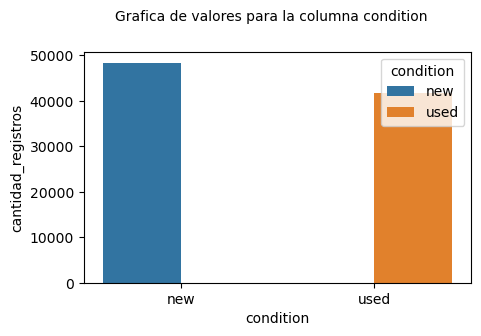

In [268]:
descr_categorico(df_EDA,"condition",is_target=True)